In [37]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

import warnings
warnings.filterwarnings("ignore")

In [38]:
# Load our data for training models
train_data = pd.read_csv("Data/train.csv")

In [39]:
#Take a look at what we see.
train_data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


It's pretty obvious here that there are a lot of 'NaN' values in some of these columns. For things like PoolQC and PoolArea, it might be that there was only a value entered if the house had a pool. Other columns like MiscFeature may have less value, but let's do some EDA to make that call.  

In [40]:
pd.set_option('display.max_rows', 100)
train_data.isna().mean().round(4)*100

Id                0.00
MSSubClass        0.00
MSZoning          0.00
LotFrontage      17.74
LotArea           0.00
Street            0.00
Alley            93.77
LotShape          0.00
LandContour       0.00
Utilities         0.00
LotConfig         0.00
LandSlope         0.00
Neighborhood      0.00
Condition1        0.00
Condition2        0.00
BldgType          0.00
HouseStyle        0.00
OverallQual       0.00
OverallCond       0.00
YearBuilt         0.00
YearRemodAdd      0.00
RoofStyle         0.00
RoofMatl          0.00
Exterior1st       0.00
Exterior2nd       0.00
MasVnrType        0.55
MasVnrArea        0.55
ExterQual         0.00
ExterCond         0.00
Foundation        0.00
BsmtQual          2.53
BsmtCond          2.53
BsmtExposure      2.60
BsmtFinType1      2.53
BsmtFinSF1        0.00
BsmtFinType2      2.60
BsmtFinSF2        0.00
BsmtUnfSF         0.00
TotalBsmtSF       0.00
Heating           0.00
HeatingQC         0.00
CentralAir        0.00
Electrical        0.07
1stFlrSF   

Ok, so there are a few variables here with a lot of missing values. I'll make the cut-off here of dropping variables with more than 10% NaN values. 

In [41]:
train_data = train_data.drop(columns=['LotFrontage','Alley','FireplaceQu','PoolQC','Fence','MiscFeature'])

### Numerical variables

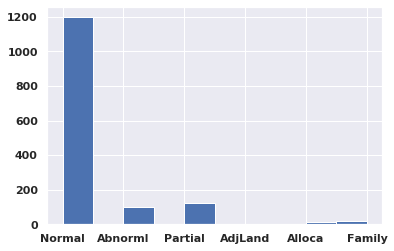

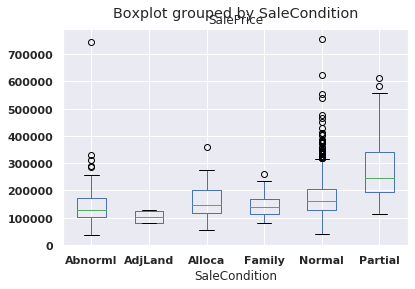

In [42]:
train_data['SaleCondition'].hist()
#Immediately it seems that maybe we want to exclude sales that are not normal, as they are rare and likely outliers.
train_data.boxplot(column='SalePrice',by='SaleCondition')

It seems that 'Normal' sales have quite a few outliers, but also that partial sales have a higher median sale value. Maybe it's not actually a great idea to drop this information.

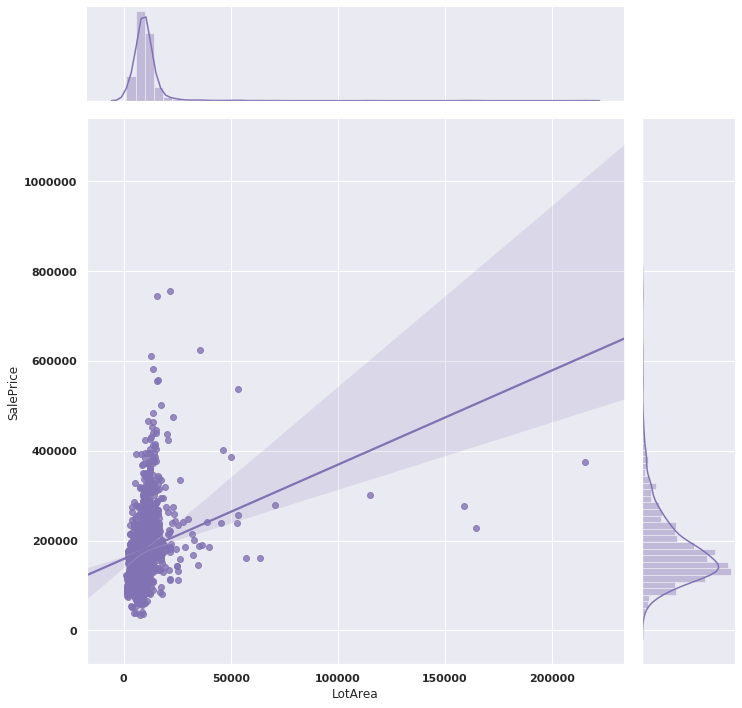

In [43]:
# Let's take a real brief look at some of the likely candidates for driving housing prices
sns.set(style="darkgrid")
g = sns.jointplot("LotArea", "SalePrice", data=train_data, kind="reg",
                   color="m", height=10)


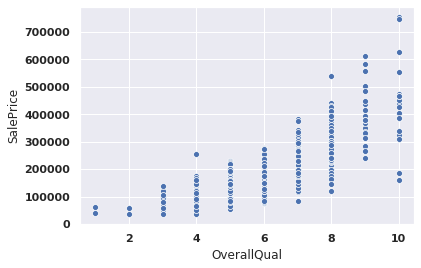

In [44]:
sns.set(style="darkgrid")
g = sns.scatterplot("OverallQual", "SalePrice", data=train_data)

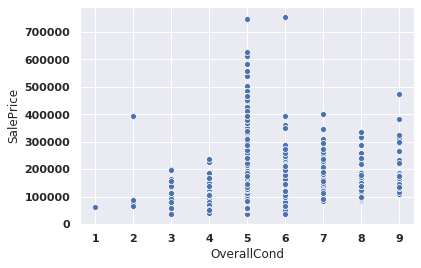

In [45]:
sns.set(style="darkgrid")
g = sns.scatterplot("OverallCond", "SalePrice", data=train_data)

Well already there are some interesting things here. In looking at the relation between square footage and sales price, it looks like there are some outliers in square footage that throw things off. Let's reexamine the relationship after we remove extreme outliers.

In [46]:
print('cut-off: {}'.format(np.percentile(train_data['LotArea'],90)))

cut-off: 14381.70000000001


In [47]:
train_data_sub = train_data[train_data['LotArea'] < np.percentile(train_data['LotArea'],90)]

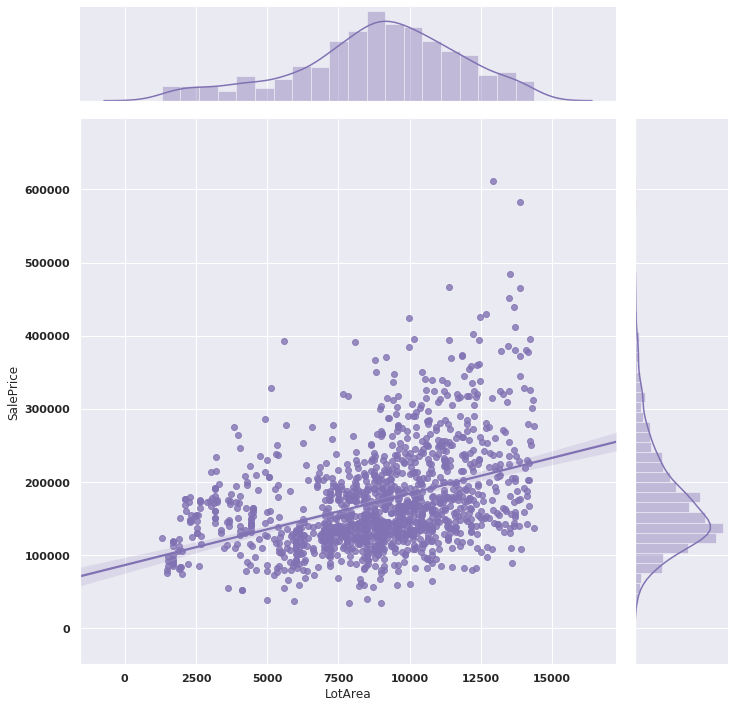

In [48]:
g = sns.jointplot("LotArea", "SalePrice", data=train_data_sub, kind="reg",
                   color="m", height=10)

While this won't let us use only one variable to predict Sale Price, this looks a lot better than previously!

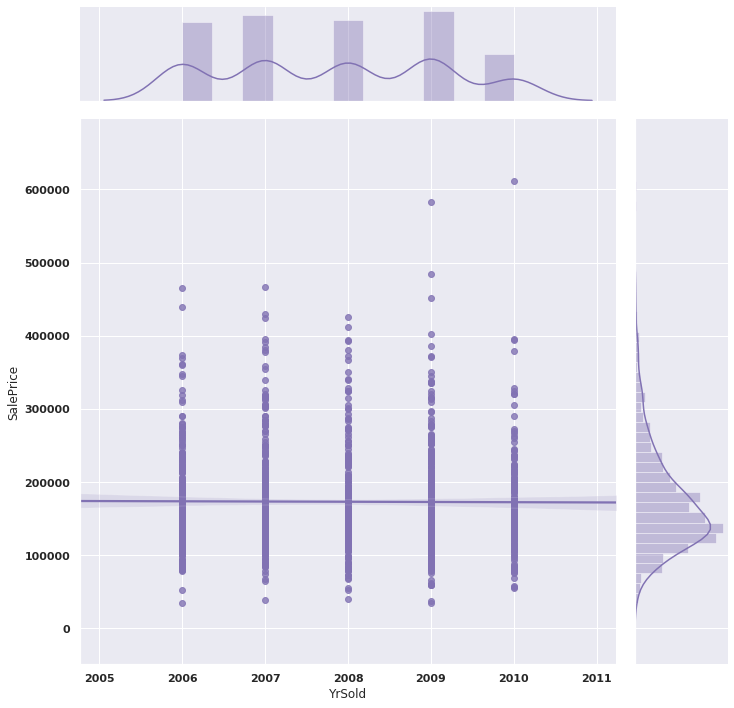

In [49]:
g = sns.jointplot("YrSold", "SalePrice", data=train_data_sub, kind="reg",
                   color="m", height=10)

Although a terrible predictor, at least this can let us go forward and drop a column!

In [50]:
train_data_sub = train_data_sub.drop(columns=['YrSold'])

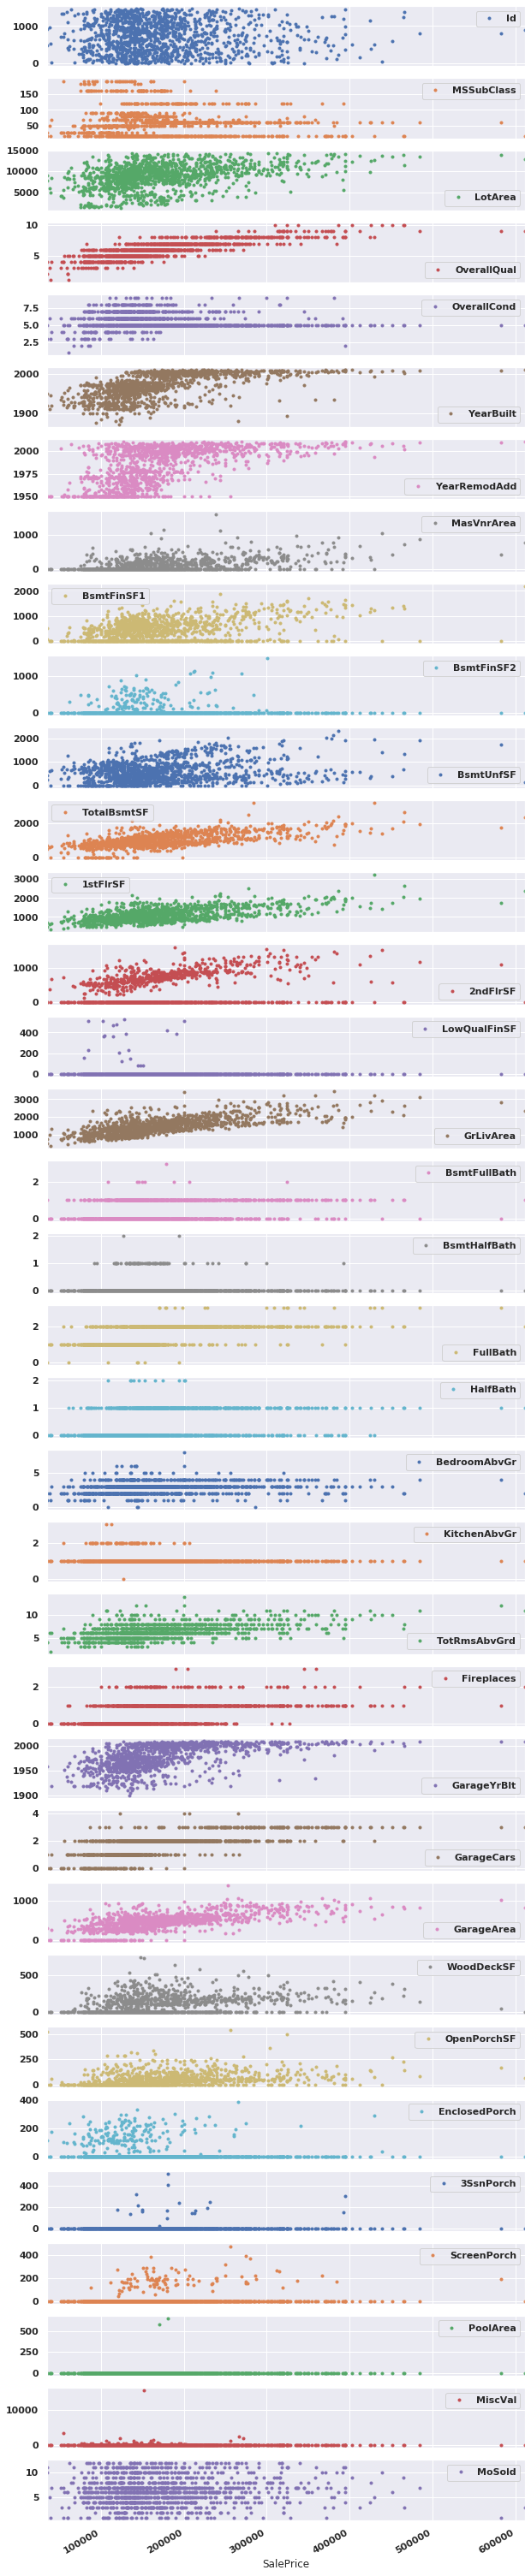

In [51]:
col = 'SalePrice'
df2 = train_data_sub.drop(col,axis=1)
df2.index = train_data_sub[col]
df2.plot(subplots=True, style='.')
plt.legend(loc='best')
fig = plt.gcf()
fig.set_size_inches(10, 60)
plt.show()

OK, so that's a lot to parse, but let's make a list of variables that seem at least to have any trend at all!
- LotArea
- MSSubClass (Maybe)
- LotFrontage
- OverallQual (Strong)
- OverallCond (Maybe)
- YearBuilt (Strong)
- Year RemodAdd
- TotalBsmtSF (Strong)
- 1stFlrSF (Strong)
- 2ndFlrSF (Weaker)
- GrLivArea (Strong)
- FullBath
- TotRmsAbvGrd (Strong)
- Fireplaces
- GarageCars
- GarageArea (Strong)
- GarageYrBlt

These are just the numerical variables, but let's start here

Ok, well that reduces the number of variables nicely. Let's subset the dataframe and check to make sure none of the variables are strongly correlated. We want to avoid multi-colinearity issues when try different regression techniques.

In [52]:
train_data_reduced = train_data_sub[['LotArea','MSSubClass','OverallQual','YearBuilt','YearRemodAdd',
                                    'TotalBsmtSF','1stFlrSF','2ndFlrSF','GrLivArea','TotRmsAbvGrd',
                                    'Fireplaces','GarageCars','GarageYrBlt','GarageArea','SalePrice']].copy()

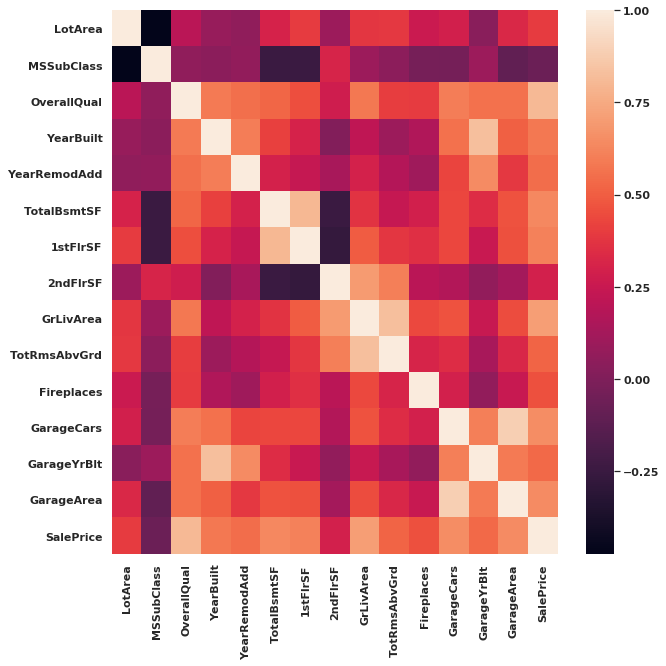

In [53]:
corr = train_data_reduced.corr() 
fig, ax = plt.subplots(figsize=(10, 10))
fig = sns.heatmap(corr)

The correlation matrix highlights some highly correlated features, such as GarageCars and GarageArea. Not very surprising, but a quantitative way to reduce co-linearity. Another pair would be 1stFlrSF and TotalBsmtSF.I will exclude 1stFlrSF as it seems slightly less correlated with SalePrice. Unsurprisingly YrBuilt and GarageYrBlt are highly correlated, I will drop GarageYrBlt by the same reasoning.

In [54]:
#train_data_reduced = train_data_reduced.drop(columns = ['GarageCars','1stFlrSF','GarageYrBlt','TotRmsAbvGrd'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd110ab5090>,
      dtype=object)

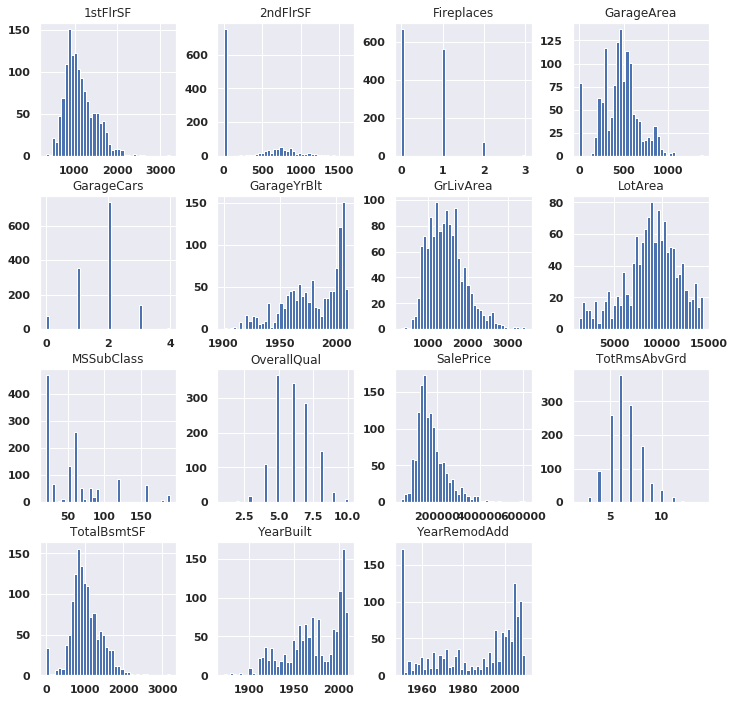

In [55]:
train_data_reduced.hist(bins=40,figsize=(12,12))

### Categorical variables

In [56]:
categorical = train_data_sub.select_dtypes(include='object')

Let's look at some box plots and get an idea of which categorical variables might strongly affect house sale price!

In [57]:
categorical = categorical.join(train_data_sub['SalePrice'])

<Figure size 576x576 with 0 Axes>

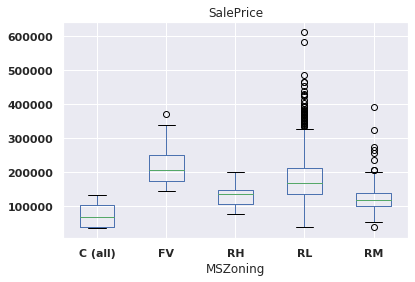

<Figure size 576x576 with 0 Axes>

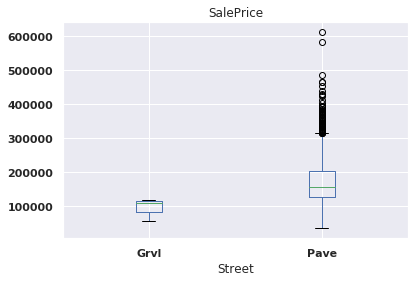

<Figure size 576x576 with 0 Axes>

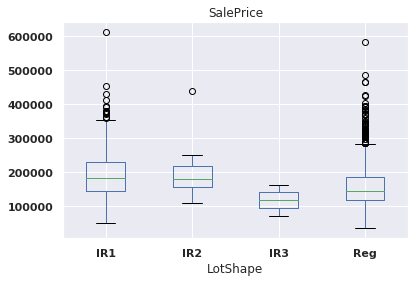

<Figure size 576x576 with 0 Axes>

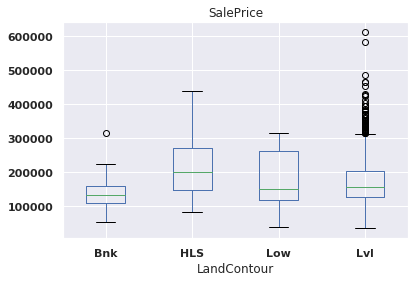

<Figure size 576x576 with 0 Axes>

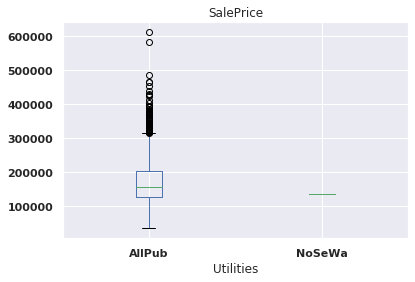

<Figure size 576x576 with 0 Axes>

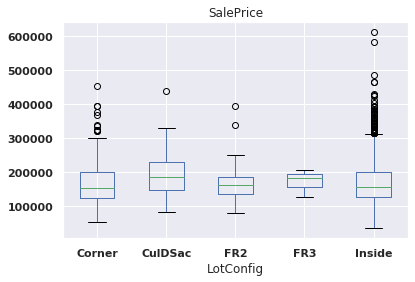

<Figure size 576x576 with 0 Axes>

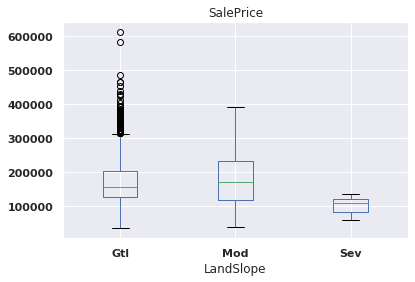

<Figure size 576x576 with 0 Axes>

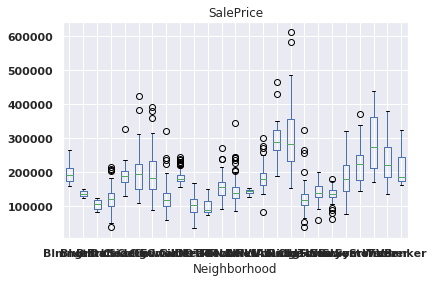

<Figure size 576x576 with 0 Axes>

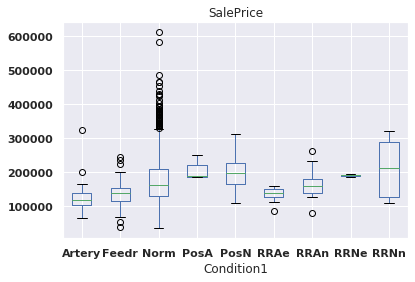

<Figure size 576x576 with 0 Axes>

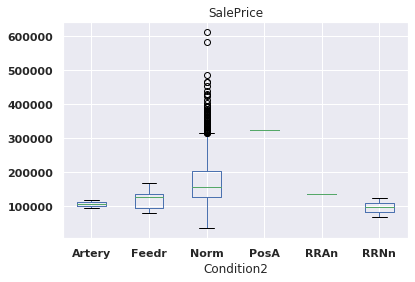

<Figure size 576x576 with 0 Axes>

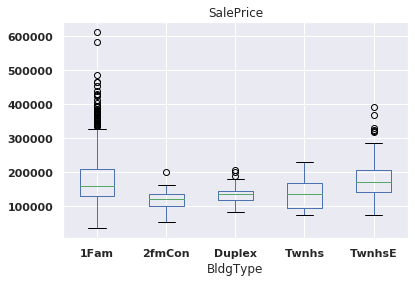

<Figure size 576x576 with 0 Axes>

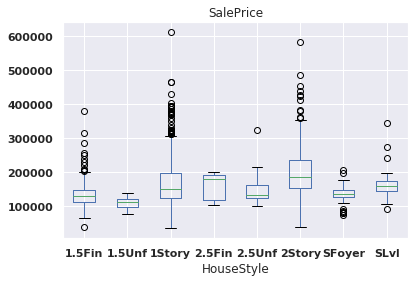

<Figure size 576x576 with 0 Axes>

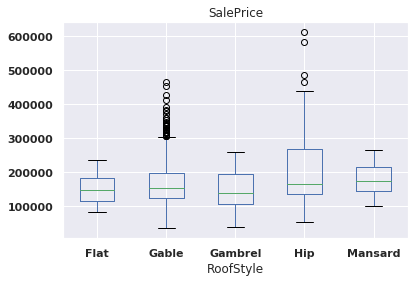

<Figure size 576x576 with 0 Axes>

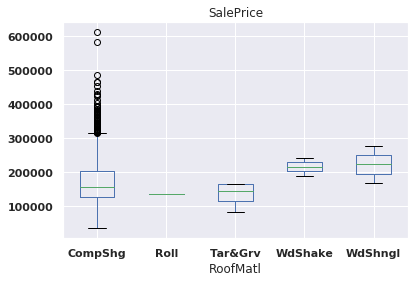

<Figure size 576x576 with 0 Axes>

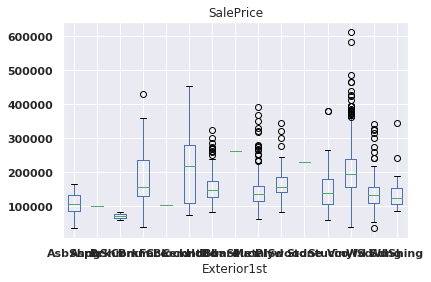

<Figure size 576x576 with 0 Axes>

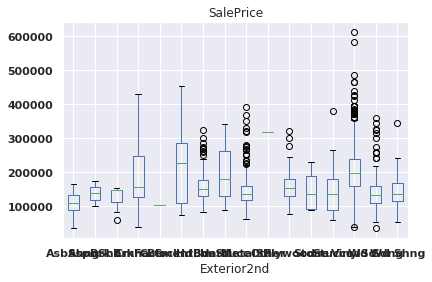

<Figure size 576x576 with 0 Axes>

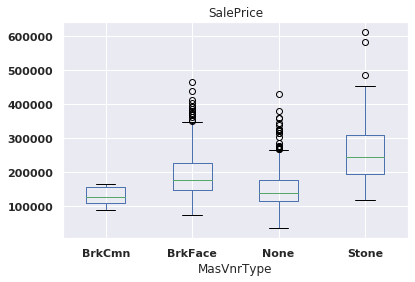

<Figure size 576x576 with 0 Axes>

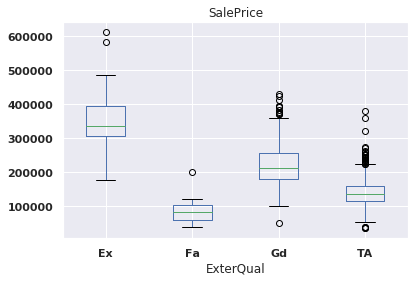

<Figure size 576x576 with 0 Axes>

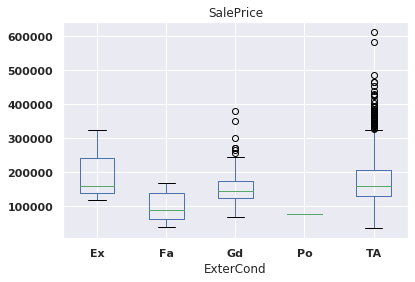

<Figure size 576x576 with 0 Axes>

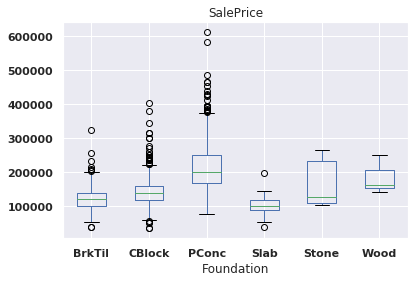

<Figure size 576x576 with 0 Axes>

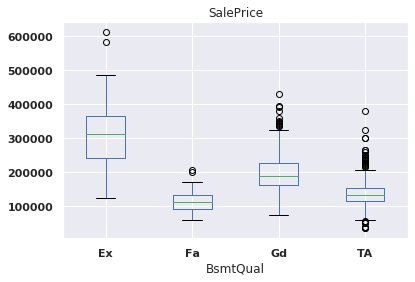

<Figure size 576x576 with 0 Axes>

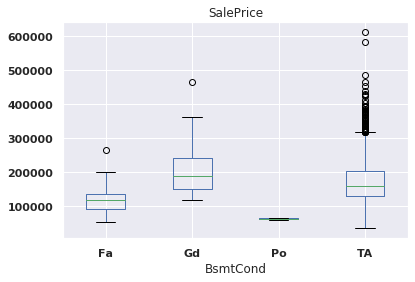

<Figure size 576x576 with 0 Axes>

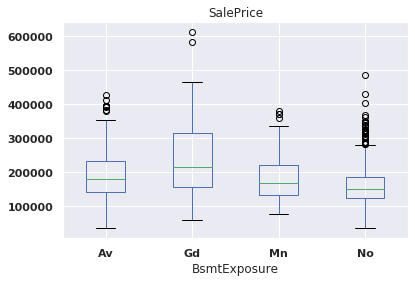

<Figure size 576x576 with 0 Axes>

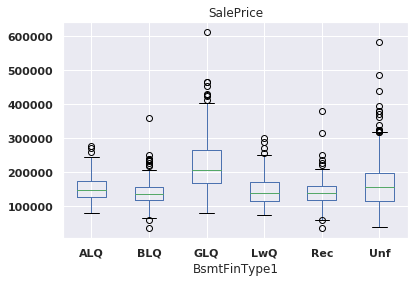

<Figure size 576x576 with 0 Axes>

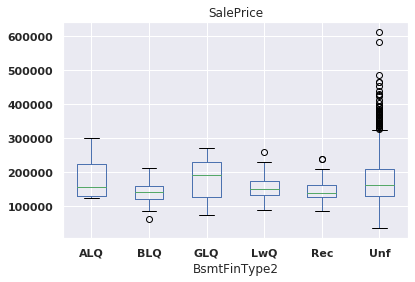

<Figure size 576x576 with 0 Axes>

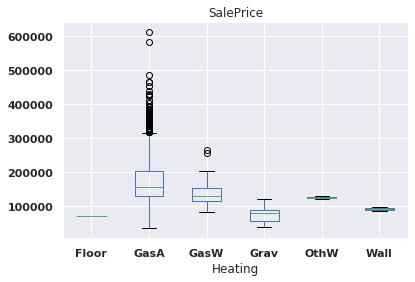

<Figure size 576x576 with 0 Axes>

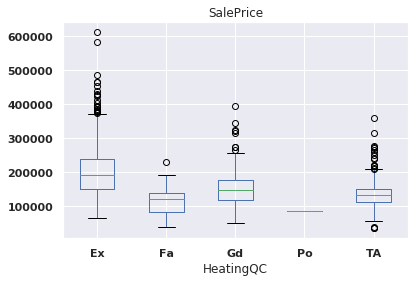

<Figure size 576x576 with 0 Axes>

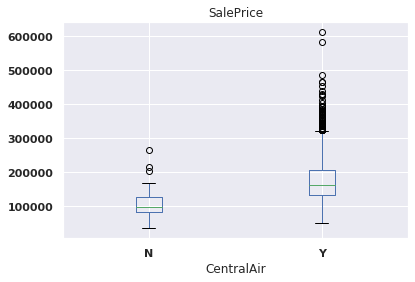

<Figure size 576x576 with 0 Axes>

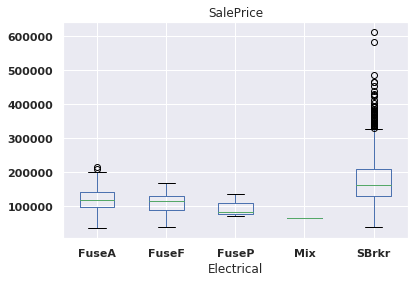

<Figure size 576x576 with 0 Axes>

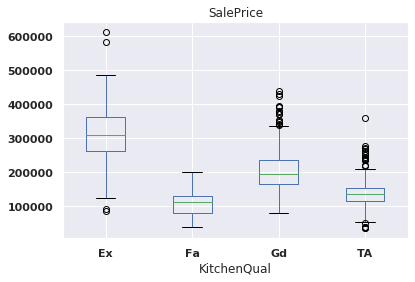

<Figure size 576x576 with 0 Axes>

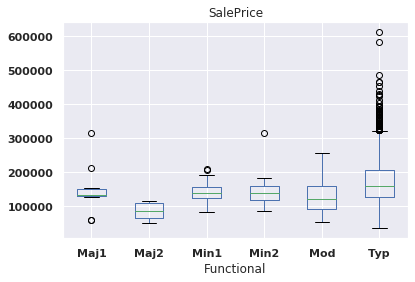

<Figure size 576x576 with 0 Axes>

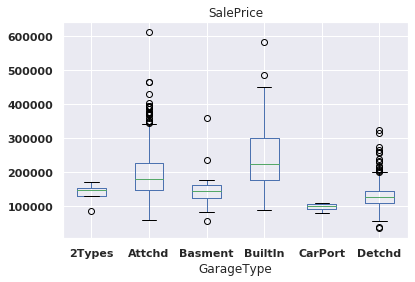

<Figure size 576x576 with 0 Axes>

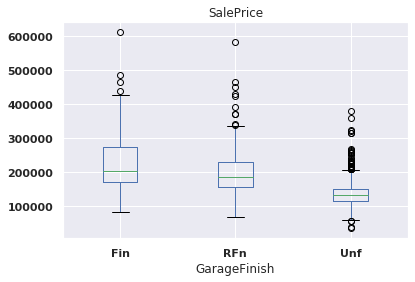

<Figure size 576x576 with 0 Axes>

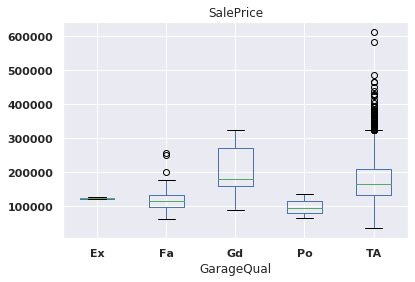

<Figure size 576x576 with 0 Axes>

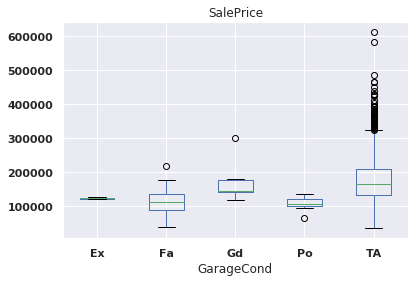

<Figure size 576x576 with 0 Axes>

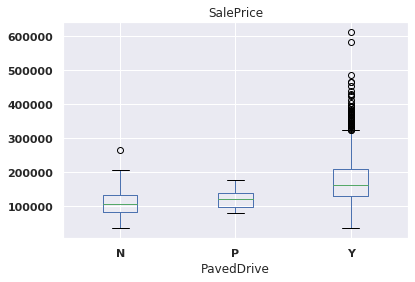

<Figure size 576x576 with 0 Axes>

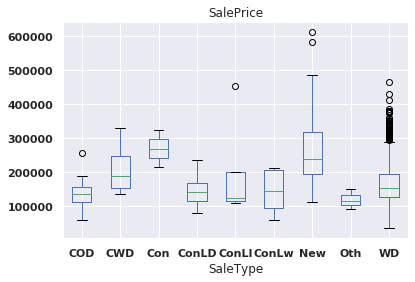

<Figure size 576x576 with 0 Axes>

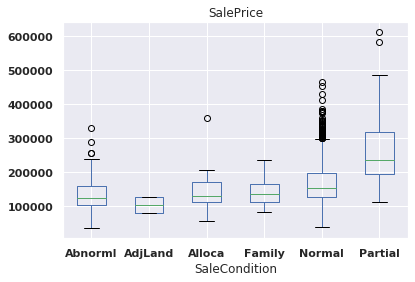

In [58]:
for col in categorical.columns:
    if col != 'SalePrice':
        plt.figure(figsize = (8,8))
        categorical.boxplot(column = 'SalePrice', by=col)
        plt.suptitle("")

We're looking here for variables that seem to have much different distributions in relation to SalePrice.

Based on this, let's make some initial selections.

In [59]:
categorical_sub = categorical[['Neighborhood',
                              'ExterQual',
                              'Exterior1st','BsmtQual',
                              'KitchenQual','GarageType','GarageFinish','SaleType']]
categorical_sub = categorical_sub.astype('category')

In [60]:
categorical_sub = categorical_sub.apply(lambda x: x.cat.codes)

In [61]:
joined_data = train_data_reduced.join(categorical_sub)
joined_data = joined_data.fillna(-1)

In [62]:
joined_data

,LotArea,MSSubClass,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,2ndFlrSF,GrLivArea,TotRmsAbvGrd,...,GarageArea,SalePrice,Neighborhood,ExterQual,Exterior1st,BsmtQual,KitchenQual,GarageType,GarageFinish,SaleType
0,8450,60,7,2003,2003,856,856,854,1710,8,...,548,208500,5,2,12,2,2,1,1,8
1,9600,20,6,1976,1976,1262,1262,0,1262,6,...,460,181500,24,3,8,2,3,1,1,8
2,11250,60,7,2001,2002,920,920,866,1786,6,...,608,223500,5,2,12,2,2,1,1,8
3,9550,70,7,1915,1970,756,961,756,1717,7,...,642,140000,6,3,13,3,2,5,2,8
4,14260,60,8,2000,2000,1145,1145,1053,2198,9,...,836,250000,15,2,12,2,2,1,1,8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,60,6,1999,2000,953,953,694,1647,7,...,460,175000,8,3,12,2,3,1,1,8
1456,13175,20,6,1978,1988,1542,2073,0,2073,7,...,500,210000,14,3,9,2,3,1,2,8
1457,9042,70,7,1941,2006,1152,1188,1152,2340,9,...,252,266500,6,0,5,3,2,1,1,8
1458,9717,20,5,1950,1996,1078,1078,0,1078,5,...,240,142125,12,3,8,3,2,1,2,8


In [63]:
target = train_data_reduced['SalePrice']
train_data_vars = joined_data.drop(columns=['SalePrice'])

In [64]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor

X_train, X_test, y_train, y_test = train_test_split(train_data_vars, target, test_size=0.33)

#Let's not get too crazy and just start with default params.
rf = RandomForestRegressor()
rf.fit(X_train,y_train)

y_pred = rf.predict(X_test)

print('RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test,y_pred))))

RMSLE: 0.16801447076199877


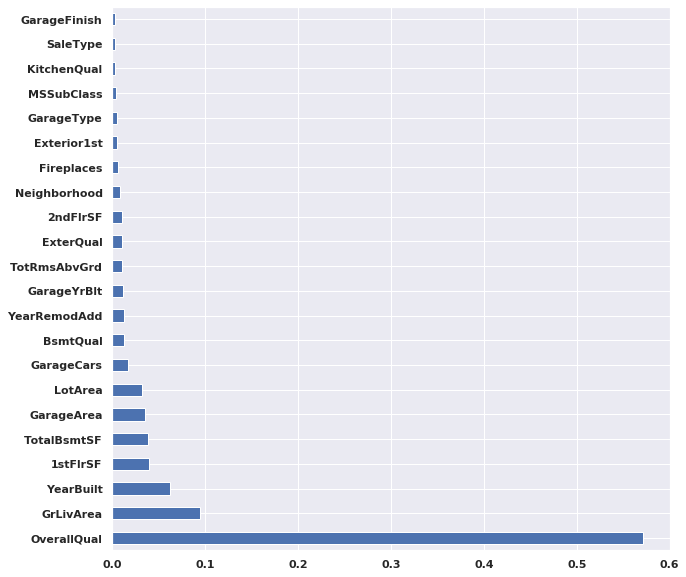

In [65]:
feat_imp = pd.Series(rf.feature_importances_,index=train_data_vars.columns)
plt.figure(figsize=(10,10))
feat_imp.nlargest(40).plot(kind="barh")

In [66]:
X_train, X_test, y_train, y_test = train_test_split(train_data_vars, target, test_size=0.33)

from xgboost import XGBRegressor
#Let's not get too crazy and just start with default params.
xg = XGBRegressor()
xg.fit(X_train,y_train)

y_pred = xg.predict(X_test)

print('RMSLE: {}'.format(np.sqrt(mean_squared_log_error(y_test,y_pred))))

[18:40:03] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSLE: 0.14698646716069638


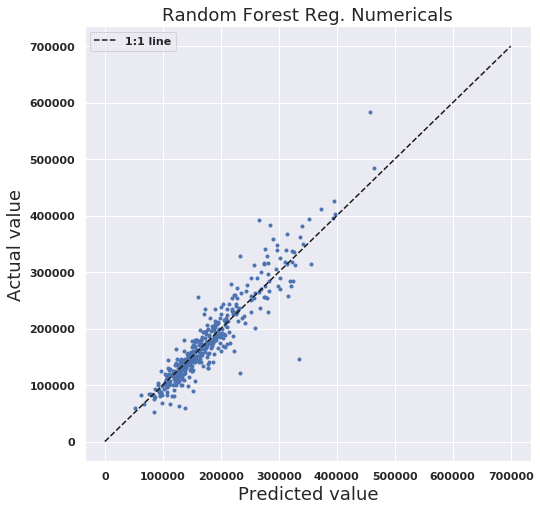

In [67]:
font = {'family' : 'sans-serif',
        'weight' : 'bold',
        'size'   : 25}

plt.rc('font', **font)

plt.rc('axes', labelsize=18)
plt.rc('axes', titlesize=18)

x = np.linspace(0,700000,1000)
y = np.linspace(0,700000,1000)
fig= plt.figure(figsize=(8,8))
plt.plot(y_pred,y_test,'.')
plt.plot(x,y,'--k',label = '1:1 line')
plt.title('Random Forest Reg. Numericals')
plt.xlabel('Predicted value')
plt.ylabel('Actual value')
plt.legend()
plt.show()

The competition metric is root mean square log error and the top test submission score is approx. 0.07. Let's check how we do submitting predictions based on this simple model.